In [82]:
using PyCall,TickTock


scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")

#psi(x) = scipyinterpolate.splev(x, spl)
#b=psi(initX)
tick()
psi_func = scipyinterpolate.splrep(initX1, state_array[4:L-3,3],k=4)
data=(scipyinterpolate.splev(initX1, psi_func))
tock()
#a.-b

tick()
psi_func=Spline1D(initX1, state_array[4:L-3,3],  k=4);
b=psi_func(initX1)
tock()
a.-b;

[ Info:  started timer at: 2023-06-02T10:32:19.444
[ Info:          0.008718292s: 8 milliseconds
[ Info:  started timer at: 2023-06-02T10:32:19.453
[ Info:          0.002346985s: 2 milliseconds


# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


# Parameters

In [37]:
m = 1
A = 0.001#0.049375#0.07#0.05#0.1124921875#0.125
run = 1

1

In [38]:
res=m;
N=2.0^m*100.0/2.0
Xf=1.0;

dx=Xf/N;
dt=round(dx,digits=10);
Nt=2.0^m*100.0/2.0
Tf=Nt*dt; #final time
print(Tf)

1.0

In [39]:
print(N)

400.0

In [40]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)

dx =0.0025
dt =0.0025
dx/dt =1.0


In [41]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"
#global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

# Grid

In [42]:
using Printf
include("./ScalarField.jl");

In [72]:
ori=0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);

initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

step size is  0.0025
the time step is 0.0025


In [44]:
"""if m==1
    initX1=chebyshev(int((L-6)))
    L1=L;
elseif m==2
    initX1=doublegrid(chebyshev(int((L1-6))))
else
    initX1=doublegrid(doublegrid(chebyshev(int((L1-6)))))
end
initX=collect(initX)
initX[4:L-3]=initX1;""";

# Initial data of m β Ψ and Ψ,x

In [45]:
using Dierckx
using Quadmath


####
#initm=Array{Float128}(undef, L)
#initbeta=Array{Float128}(undef, L)
#initpsi=Array{Float128}(undef, L)
#initderpsi=Array{Float128}(undef, L)
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#0.01#0.7#0.01#0.7#0.7#0.7#0.01#0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,4],  k=4);

In [46]:
##AUX
auxinitm=zeros((L-6)*2+5);
auxinitbeta=zeros((L-6)*2+5);
auxinitpsi=zeros((L-6)*2+5);
auxinitderpsi=zeros((L-6)*2+5);
auxinitX=range(round(ori-3.0*dx/2,digits=10), stop=Xf+3.0*dx/2, step=dx/2)
auxinitX1=auxinitX[4:length(auxinitX)-3]
auxL=length(auxinitX)

auxstate_array=[auxinitm auxinitbeta auxinitpsi auxinitderpsi auxinitX];

#PSI
r0=0.7
sigma=0.3
auxinitpsi[4:auxL-3] = init_gaussian(auxinitX1,r0,sigma,A)

auxstate_array[:,3] = auxinitpsi
auxstate_array = ghost(auxstate_array)

#PSI,X FROM PSI
auxinitderpsi[4:auxL-3] = init_gaussian_der(auxinitX1,r0,sigma,A)
auxstate_array[:,4] = auxinitderpsi
auxstate_array=ghost(auxstate_array)

####

auxderpsi_func = Spline1D(auxinitX[4:auxL-3], auxstate_array[4:auxL-3,4],  k=4);

In [47]:
"""integ=integrator(initX,derpsi_func)
plot(initX1, integ[4:L-3],xlim=[0,0.001])"""

"integ=integrator(initX,derpsi_func)\nplot(initX1, integ[4:L-3],xlim=[0,0.001])"

In [48]:
##AUX
y0=[0 0 0]
auxstate_array[4:auxL-3,1:3] = n_rk4wrapper(RHS,y0,auxinitX[4:auxL-3],0,auxderpsi_func,auxstate_array[:,:]);

In [49]:
y0=[0 0 0]
#state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func,state_array[:,:],auxstate_array); #ghost grid

state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func,state_array[:,:]);

state_array = ghost(state_array);

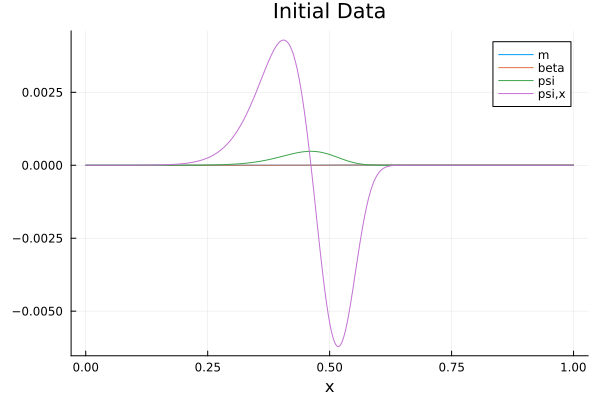

In [50]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX[4:L-3], state_array[4:L-3,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [51]:
using CSV, Tables, Printf
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

open(dir*"/res$res/data.txt", "w") do file
    print_muninn(file, 0, state_array[:,1:5])
end

In [52]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
monitor_ratio = zeros(L)
CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

In [53]:
ginit=dt_scale(initX,state_array[:,1],state_array[:,2],dx)
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

1.0


 ## Time evolution

fixed grid

In [54]:
finaltime=1.3#2#1.3#0.08*2#0.005*10*5#1#0.9#0.8#0.04*5*4#length(T)-1
evol_stats, T_interp = timeevolution(state_array,finaltime,dir*"/res$res",run,auxstate_array);
CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);

iteration 10 dt is 0.0025, time of iteration is 0.025
iteration 20 dt is 0.0025, time of iteration is 0.05
iteration 30 dt is 0.0025, time of iteration is 0.075
iteration 40 dt is 0.0025, time of iteration is 0.1
iteration 50 dt is 0.0025, time of iteration is 0.125
iteration 60 dt is 0.0025, time of iteration is 0.15
iteration 70 dt is 0.0025, time of iteration is 0.175
iteration 80 dt is 0.0025, time of iteration is 0.2
iteration 90 dt is 0.0025, time of iteration is 0.225
iteration 100 dt is 0.0025, time of iteration is 0.25
iteration 110 dt is 0.0025, time of iteration is 0.275
iteration 120 dt is 0.0025, time of iteration is 0.3
iteration 130 dt is 0.0025, time of iteration is 0.325
iteration 140 dt is 0.0025, time of iteration is 0.35
iteration 150 dt is 0.0025, time of iteration is 0.375
iteration 160 dt is 0.0025, time of iteration is 0.4
iteration 170 dt is 0.0025, time of iteration is 0.425
iteration 180 dt is 0.0025, time of iteration is 0.45
iteration 190 dt is 0.0025, time

 ## Movie of the evolution

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
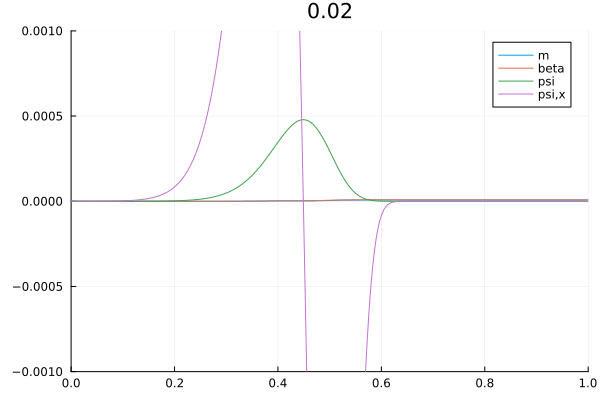

In [107]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 10:10:80
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    temp=round(n*dt,digits=2)
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], title="$temp", ylim=[-0.001, 0.001],xlim=[0.0, 1])#, xlim=[0, 0.1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 10)

In [113]:
epsilon(dt,dx)

0.015625

In [114]:
1000*dt

1.25

In [115]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 10:10:1000#length(T)-1
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 5)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res2/monitor_ratio10.csv" is not a valid file or doesn't exist

In [208]:
epsilon(dx,dt)

0.015625

In [316]:
dt

0.001

0.0078125

In [31]:
state_array[:,4]

207-element Vector{Float64}:
 -2.365518250288725e-9
 -9.136367842295702e-10
 -2.14954583648039e-10
  0.0
  6.986152586784135e-13
  5.661291067212787e-11
  4.3721453478448e-10
  1.681826439904089e-9
  4.6038562839992895e-9
  1.0296050405382373e-8
  2.0137407051887777e-8
  3.5801665455811194e-8
  5.926726083699171e-8
  ⋮
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [37]:

auxinitX= range(0,1,step=dx)
println(Der(state_array,6,4,auxinitX))

spl= Spline1D(initX[4:L-3], state_array[4:L-3,4],  k=4);
println(derivative(spl, auxinitX[6]))

3.017168193837207e-8
0.00017208804225226937


In [53]:
println(Der(state_array,60,4,initX))

spl= Spline1D(initX[4:L-3], state_array[4:L-3,4],  k=4);
println(derivative(spl, initX[60]))

println(derivative(spl, initX[60]).-Der(state_array,60,4,initX))

0.014407887381376435
0.014407810796996974
-7.658437946138352e-8


In [30]:
using Roots
find_zero(derpsi_func, (0,0.5), Bisection())

0.2713799770174635

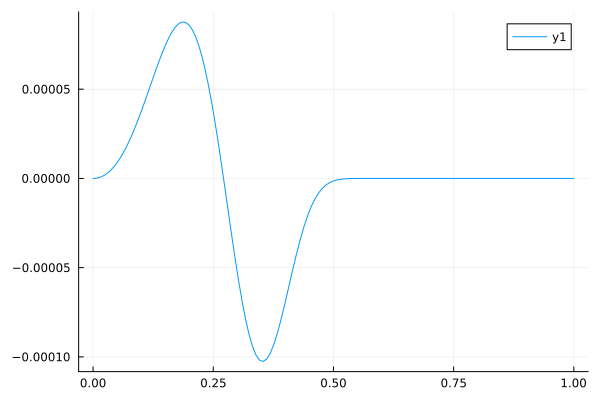

In [23]:
using Plots
plot(initX1, derpsi_func(initX1))

In [66]:
m_func = Spline1D(initX[4:L-3],state_array[4:L-3,1],k=4)
beta_func = Spline1D(initX[4:L-3],state_array[4:L-3,2],k=4)
der_funcs=[derivative(m_func,initX) derivative(beta_func,initX) derivative(derpsi_func,initX)]
der_funcs[2,1] # i is gridpoint, j is function

-1.5086563198078306e-16

In [58]:
derivative(m_func,initX)

207-element Vector{Float64}:
 -3.6298572062043756e-16
 -1.5086563198078306e-16
 -4.2846357130174216e-17
 -3.826449677788914e-18
  1.2955367671949918e-18
  7.621048595599677e-18
  5.1885306005563256e-17
  2.109734086495333e-16
  6.633715930192716e-16
  1.768094158067992e-15
  4.2032891114686175e-15
  9.186535719427543e-15
  1.882331476354324e-14
  ⋮
 -3.776355223175436e-19
 -1.7646519734465227e-20
  1.0587911840678348e-20
  2.2651714422785337e-19
 -1.4750589189488752e-19
 -3.7472920178666525e-19
  6.78866591885402e-20
 -2.96640705754548e-20
  5.421010862427541e-19
  3.1064380724396854e-18
  8.986602830812212e-18
  1.9505851304156383e-17

In [166]:
derivative(derpsi_func,initX1[1])

3.9599527939805415e-10

In [163]:
derivative(derpsi_func,initX1)[1]

3.9599527939805415e-10

In [161]:
derivative(derpsi_func,initX)[4]

3.9599527939805415e-10

In [ ]:
aux=doublegrid(initX1)

using Plots
plot(aux, derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A), xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, ylim=[0, 10^(-13)])

##

x2=aux
y2=derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A);

##

double_resolution=y2
basis_resolution=y1
xs = ( x1, x2 )
ys = ( basis_resolution, double_resolution*16*4 )
p = plot()
map(x->plot!(x[1],x[2],xaxis="x",title="Interpolation error", legend=false), zip(xs, ys))
display(p)
     